<table>
    <tr>
        <td> 
            <img src="Slide1.png"align="center" width="250"/> 
        </td> 
        <td>
            <img src="Slide2.png"align="center"width="250"/>
        </td>
        <td>
            <img src="Slide3.png"align="center"width="250"/>
        </td>
     </tr>
</table>

# <center> CUWALID training </center>
CUWALID is an integrated model used to obtain actionable forecasts for hydrological components in drylands. It consists of a main hydrological model (DRYP) which allows to estimate the partioning of the water balance. This hydrological model is driven by two major climate inputs **precipitation** and **potential evapotranspiration (PET)**. The driving climate variables are obtained based on stochastic models integrated in the system. **STORM** is the precipitation model and **stoPET** is the PET model that generates the required driving climate variables. Here, we disscuss the stoPET model and how it works in the CUWALID system.

## 1. stoPET
stoPET is a stochastic PET generator over the globe (55N - 55S). The model consists of two scripts **run_stoPET.py** and **stoPET_v1.py**  where the first one is used to provide the necessary inputs and run the model. The second one is the script containing the functions to generate the PET values. For training purposes, the function in the run_stoPET.py is provided below. Details of the model description can be found in the following paper <a href="https://doi.org/10.5194/gmd-16-557-2023" target="_blank">stoPET paper</a> and you can download the model from                                                          <a href="https://doi.org/10.6084/m9.figshare.19665531" target="_blank">this link</a>.


In [28]:
# This is for showing plots 
# interactively in Jupiter notebook
%matplotlib inline

In [60]:
import sys
import numpy as np
from stoPET_v1 import *
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap

In [30]:
def run_stoPET():
    ## ----- CHANGE THE INPUT VARIABLES HERE -----##
    datapath = 'stopet_parameter_files/'
    outputpath = 'results/'
    runtype =  'single' #'regional' #
    startyear = 2000
    endyear = 2010

    # Single point stoPET run
    latval = 1.73
    lonval = 40.09

    # Regional stoPET run
    latval_min = -5.5
    latval_max = -4.5 #5.5
    lonval_min = 33.0
    lonval_max = 34.5 #42.0
    locname = 'Wajir' #'Turkana1' #

    number_ensm = 2
    tempAdj = 3
    deltat = 1.5
    udpi_pet = 5

    ## ------ NO CHANGES BELLOW THIS -------------##
    if runtype == 'single':
            for ens_num in np.arange(0,number_ensm):
                    stoPET_wrapper_singlepoint(startyear, endyear, 
                                               latval, lonval, locname,
                                               ens_num,datapath, outputpath, 
                                               tempAdj, deltat, udpi_pet)
    elif runtype == 'regional':
            for ens_num in np.arange(0,number_ensm):
                    stoPET_wrapper_regional(startyear, endyear, 
                                            latval_min, latval_max, 
                                            lonval_min, lonval_max,
                                            locname, ens_num, datapath, 
                                            outputpath, 
                                            tempAdj, deltat, udpi_pet)
    else:
            raise ValueError('runtype only takes single and regional ... please check!')



### 1.1 Changing input parameters
The above function is used to run the stoPET model and generate the required PET values. There are input parameters that are required to run it. The user can change these parameters in this function. stoPET can run in two types: one is a **single point run** and two is a **regional run**. If a single point run is selected, the user will need to provide the **lat/lon** of the specific location and the model will choose the nearest grid point to generate the PET value. If a regional run is selected, the user will need to provide the **four corners of a rectangle** that contain the region of interest. The user also needs to provide the **start year** and **end year** for the data and a **local name** to differentiate the region or location.

### 1.2 Adjusting for temperature increase
If the user wants to adjust the PET values to account for increasing temperature,  they can provide one of the three mothods included in the model **(tempAdj)**. This is an integer number with values 1, 2, or 3. Each of these numbers represents what method to use for the model to account for temperature adjustment on future PET. Method 1 = 1, Method 2 = 2, Method 3 = 3 (Refer to the <a href="https://doi.org/10.5194/gmd-16-557-2023" target="_blank">stoPET paper</a>  for the description of each method).

       1. Method 1: user-defined percentage step change in annual PET
       2. Method 2: step change in PET based on a user-defined change in atmospheric temperature
       3. Method 3: progressive change in PET based on the historical trend in hPET

If the user chooses Method 1, the value used to increase the PET given as a percentage **(udpi_pet)**, will be used. If Method 2 is chosen, the value of the increased temperature given as **(deltat)** will be used. If Method 3 is chosen, **(deltat)** will be used and the **(udpi_pet)** will be ignored. 

The user also needs to provide how many ensembles of run are needed **(number_ensm)**. Once the user provides the required input values, the model can be executed using the following function.

In [31]:
run_stoPET()

stoPET running ...
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
stoPET finished successfully.
stoPET running ...
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
stoPET finished successfully.


As seen in the output value the model generated eleven years (2000 - 2010) single point PET. stoPET ran twice as the number of ensembles given is two.

### 1.3 Output
Once we run the model, the outputs will be saved in the output folder user provided. The output of these functions will be written in the output directory provided, where the model creates a new named directory `outputpath+locname+_E + number_ensm +_stoPET/`. 
    
For the single point run, stoPET generates text files `year_latval+_+lonval+_+tempAdj+stoPET.txt` and `year_latval+_+lonval+_+tempAdj+AdjstoPET.txt`. The first file is the PET generated without accounting for any adjustment for temperature. The second file is the adjusted PET based on the user’s choice (tempAdj). If one just wants to avoid any temperature change adjustment in the model, just use the first file output and ignore the second file.

**Example:
1994_3.8_36.6_3_stoPET.txt and 1994_3.8_36.6_3_AdjstoPET.txt**

stoPET output are hourly PET values of the year has 8760 hours for normal years and 8784 for leap years. Hence, in procesing the values, notice these array length for each year.

### 1.4 Post processing and visualization
Here we have a basic script to  analyse the generated PET data and visulize it through simple plots. The script is named as **post_processing_stopet.py** and it consists of functions that helps to process the hourly data and plot the values. The following functions are available currently but you can add any additional functions you would like to have.

    1. leap_remove(timeseries) 
    2. running_mean(timeseries, n)
    3. aggregate_data(timeseries, period)
    4. timeseries_plot(data, xlabel, ylabel, title, plotpath, fname)
    5. comparison_timeseries_plot(data_1, data_2, label_1, label_2, xlabel, ylabel, title, plotpath, fname)
    6. comparison_density_plot(data_1, data_2, label_1, label_2, xlabel, ylabel, title, plotpath, fname)
    7. plot_spatial(data, lats, lons, cmap , title, cbar_label, climin, climax, plotpath, figfname)

You can get the details of the function input parapemters by using the folowing help function after importing the script.
**help(script.function)** 

**Example: help(leap_remove)**

**Note:**
If a user wants multi year values comparison one must write a simple script to append the time series of each year before using the plotting function. 

In [32]:
from post_processing_stopet import *
help(leap_remove)

Help on function leap_remove in module post_processing_stopet:

leap_remove(timeseries)
    This function removes leap days from a time series 
    param timeseries: array containing daily time series
    param datastartyear: start year of the input data
    output data: time series with the leap days removed.



# <font color='red'>Kenya 1996 data doesn't exist</font>

**Example:** let us remove the leap year data from 1996 timeseries
first read the 1996 PET data and check the array length

In [34]:
data = np.genfromtxt('results/Kenya_E0_StoPET/1996_3.8_36.6_3_stoPET.txt')
print(len(data))
new_data = leap_remove(data)
print(len(new_data))

FileNotFoundError: results/Kenya_E0_StoPET/1996_3.8_36.6_3_stoPET.txt not found.

As seen above the origional data has a length of 8784 which is 366 days of hourly data. After we use the remove leap year function the new data has a length of 8760 which is 365 days of hourly values.

### <span style='background :yellow' > Example 1 </span>
Now lets do a simple exercise based on a 10 year data for a single location in Eastern Kenya (Wajir).

    * lat = 1.73
    * lon = 40.09
    * start year = 2000
    * end year = 2010
    * two ensembles
    * using Method 3 for temperature adjustment
    * temperature increase of 1.5 degrees

Adjust the **run_stoPET.py** acordingly and run to generate the PET data

In [37]:
def run_stoPET():
    ## ----- CHANGE THE INPUT VARIABLES HERE -----##
    datapath = 'stopet_parameter_files/'
    outputpath = 'results/'
    runtype =  'single' #'regional' #
    startyear = 2000
    endyear = 2010

    # Single point stoPET run
    latval = 1.73
    lonval = 40.09

    # Regional stoPET run
    latval_min = -5.5
    latval_max = -4.5 #5.5
    lonval_min = 33.0
    lonval_max = 34.5 #42.0
    locname = 'Wajir' #'Turkana1' #

    number_ensm = 2
    tempAdj = 3
    deltat = 1.5
    udpi_pet = 5

    ## ------ NO CHANGES BELLOW THIS -------------##
    if runtype == 'single':
            for ens_num in np.arange(0,number_ensm):
                    stoPET_wrapper_singlepoint(startyear, endyear, 
                                               latval, lonval, locname,
                                               ens_num,datapath, outputpath, 
                                               tempAdj, deltat, udpi_pet)
    elif runtype == 'regional':
            for ens_num in np.arange(0,number_ensm):
                    stoPET_wrapper_regional(startyear, endyear, 
                                            latval_min, latval_max, 
                                            lonval_min, lonval_max,
                                            locname, ens_num, datapath, 
                                            outputpath, 
                                            tempAdj, deltat, udpi_pet)
    else:
            raise ValueError('runtype only takes single and regional ... please check!')


In [38]:
run_stoPET()

stoPET running ...
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
stoPET finished successfully.
stoPET running ...
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
stoPET finished successfully.


Now let us make the visulization of the daily time series of PET for the first year (2000). Notice 2000  is a leap year so first we need to remove the leap year values since it won't be necessary for now

In [39]:
# read the PET data for the year without temperature adjustment
data_1 = np.genfromtxt('results/Wajir_E0_StoPET/2000_1.73_40.09_3_stoPET.txt')
# read the PET data for the year with adjusted temeperature
data_2 = np.genfromtxt('results/Wajir_E0_StoPET/2009_1.73_40.09_3_AdjstoPET.txt')
# lets remove the leap year day data
data_1 = leap_remove(data_1)
data_2 = leap_remove(data_2)
# check the length of the array
print(len(data_1))
print(len(data_2))

8760
8736


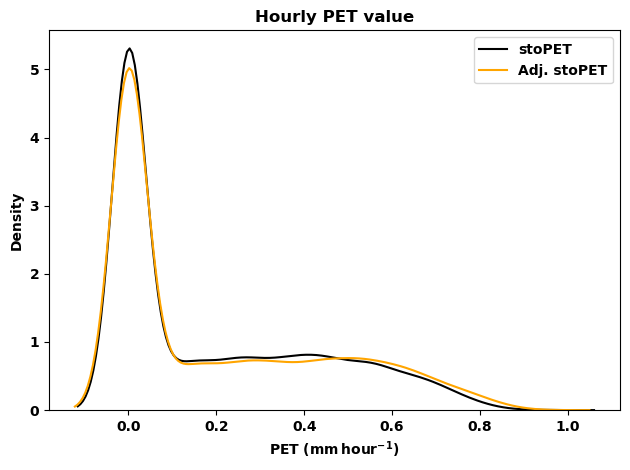

In [41]:
# Density plot
label_1 = 'stoPET'
label_2 = 'Adj. stoPET'
xlabel = 'PET ($\mathbf{mm\,hour^{-1}}$)' 
ylabel = 'Density' 
title = 'Hourly PET value' 
plotpath = './plots/' 
fig=plt.figure()
# Draw the density plot
sns.kdeplot(data_1,  color = 'k',label = label_1)
# Draw the density plot
sns.kdeplot(data_2, color = 'orange',label = label_2)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title,fontweight='bold') 
plt.legend(loc='best')
plt.tight_layout() 

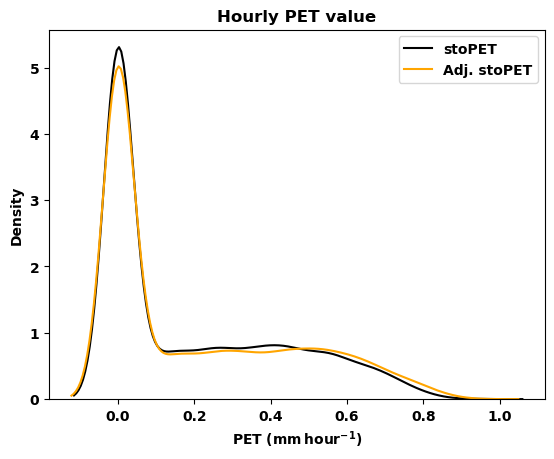

In [42]:
# Now lets plot the timeseres for both PET 
# values to visulize the daily timeseris of 
# non-adjusted and adjusted PET 
label_1 = 'stoPET'
label_2 = 'Adj. stoPET'
xlabel = 'PET ($\mathbf{mm\,hour^{-1}}$)' 
ylabel = 'Density' 
title = 'Hourly PET value' 
plotpath = './plots/' 
fname = 'Wajir_2000_hourly_density_stoPET.png'
# by using the function for plotting from the 
# post_processing_stopet.py the figures will be 
# saved in the folder user provided.
comparison_density_plot(data_1, data_2, label_1, label_2, 
                        xlabel, ylabel, title, plotpath, fname)

Now lets make the daily and monthly aggregate for the two datasets using the **aggregate_data(timeseries, period)** function.

In [43]:
# daily
data_1_day = aggregate_data(data_1, 'day')
data_2_day = aggregate_data(data_2, 'day')
print(len(data_1_day))
print(len(data_2_day))
# check for the array length
# monthly
data_1_month = aggregate_data(data_1, 'month')
data_2_month = aggregate_data(data_2, 'month')
# check for the array length
print(len(data_1_month))
print(len(data_2_month))

365
364
12
12


Now lets plot the timeseres for both PET values to visulize the daily timeseris of non-adjusted and adjusted PET. 

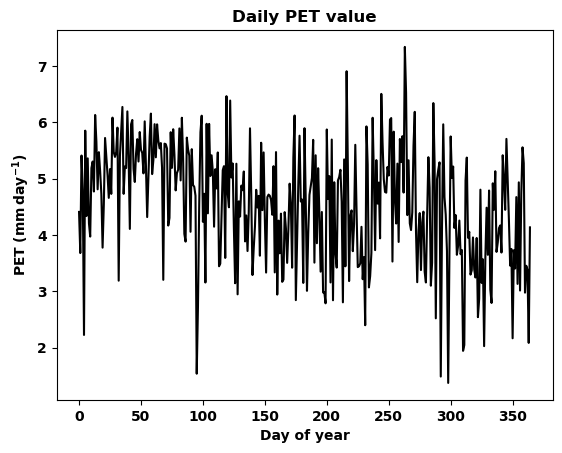

In [44]:
data = data_1_day
xlabel = 'Day of year'
ylabel = 'PET ($\mathbf{mm\,day^{-1}}$)' 
title = 'Daily PET value' 
plotpath = './plots/' 
fname = 'Wajir_2000_daily_stoPET.png'
timeseries_plot(data, xlabel, ylabel, title, plotpath, fname)

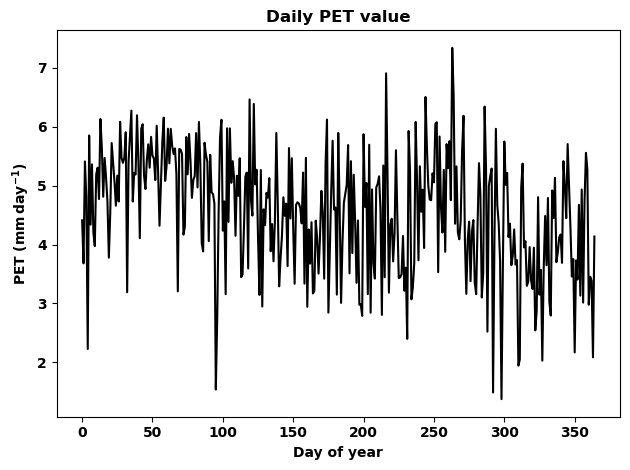

In [45]:
# This is just to show the plots in the document the function 
# already saved the plot in the plots folder.
fig=plt.figure()
plt.plot(data,'k')
plt.ylabel(ylabel)  
plt.xlabel(xlabel)  
plt.title(title,fontweight='bold') 
plt.tight_layout() 

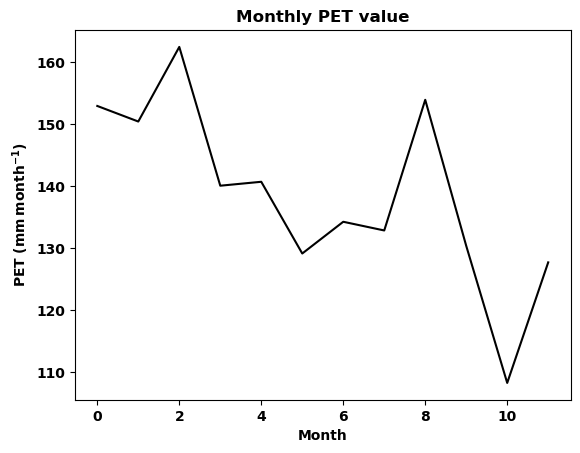

In [46]:
# Now lets plot the timeseres for the monthly PET values of the year 2000.
data = data_1_month
xlabel = 'Month'
ylabel = 'PET ($\mathbf{mm\,month^{-1}}$)' 
title = 'Monthly PET value' 
plotpath = './plots/' 
fname = 'Wajir_2000_monthly_stoPET.png'
timeseries_plot(data, xlabel, ylabel, title, plotpath, fname)

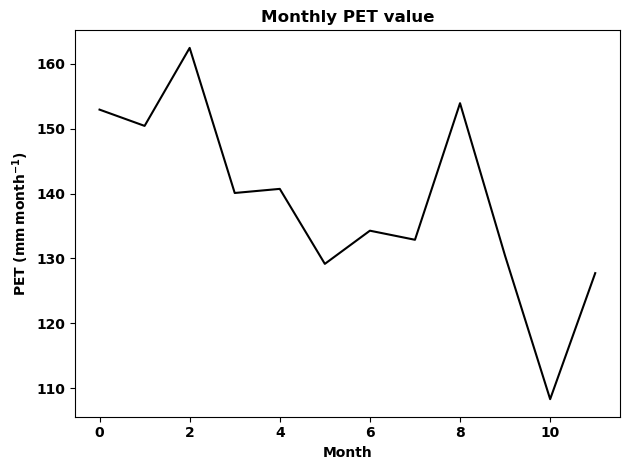

In [47]:
# This is just to show the plots in the document the function 
# already saved the plot in the plots folder.
fig=plt.figure()
plt.plot(data,'k')
plt.ylabel(ylabel)  
plt.xlabel(xlabel)  
plt.title(title,fontweight='bold') 
plt.tight_layout() 

Now lets plot the annual PET values and compare the temperature adjusted PET with non adjusted PET. Remember stoPET provide one file for each year so we need to loop through each year data and concatenate the values before plotting.

In [49]:
# first lets make the year list
years = np.arange(2000,2011)
# create empty array
data_1_year = []  # this is non adjusted PET
data_2_year = []  # this is the adjusted PET
# make a loop and estimate the annual PET value for both data
for i in range (0, len(years)):
    year = years[i]
    data_1 = np.genfromtxt('results/Wajir_E0_StoPET/%s_1.73_40.09_3_stoPET.txt'
                           %year)
    data_2 = np.genfromtxt('results/Wajir_E0_StoPET/%s_1.73_40.09_3_AdjstoPET.txt'
                           %year)
    # make the annual aggregate
    data_1_val = aggregate_data(data_1, 'year')
    data_2_val = aggregate_data(data_2, 'year')
    # append the data to the empty array
    data_1_year = np.append(data_1_year, data_1_val)
    data_2_year = np.append(data_2_year, data_2_val)
    print(year)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


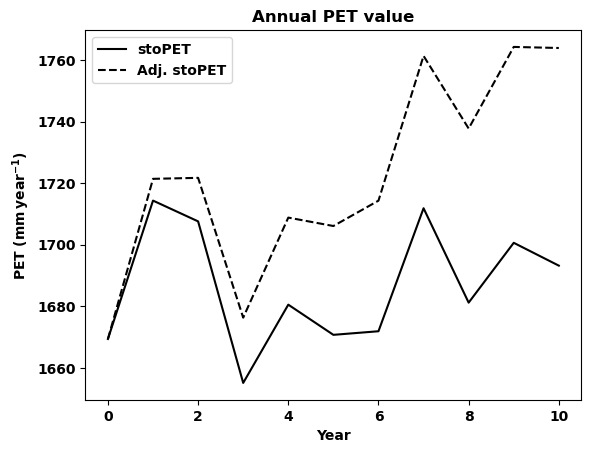

In [50]:
# now let us plot the two datasets for comparison
data_1 = data_1_year
data_2 = data_2_year
label_1 = 'stoPET'
label_2 = 'Adj. stoPET'
xlabel = 'Year'
ylabel = 'PET ($\mathbf{mm\,year^{-1}}$)' 
title = 'Annual PET value' 
plotpath = './plots/' 
fname = 'Wajir_annual_stoPET_comparison.png'
comparison_timeseries_plot(data_1, data_2, label_1, label_2, 
                           xlabel, ylabel, title, plotpath, fname)

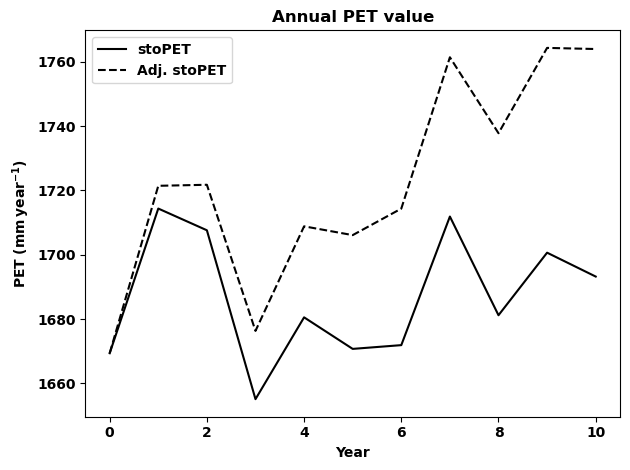

In [51]:
# This is just to show the plots in the document the function 
# already saved the plot in the plots folder.
fig=plt.figure()
plt.plot(data_1,'k', label=label_1)
plt.plot(data_2,'k--', label=label_2)
plt.ylabel(ylabel)  
plt.xlabel(xlabel)  
plt.title(title,fontweight='bold') 
plt.legend(loc='best')
plt.tight_layout() 

---
## <span style='background :red' > EXERCISE 1 </span>
Based on the above examples please try to do the folowing.

    1. Generate a 15 year dataset for the location of your choice.
    2. use each method of temperature adjustment (Method 1, Method 2 and Method 3) separatelly.
    3. generate 3 plots (one for each method) comparing the values of the annual PET and adjusted PET.
---   

### 1.5 Generating regional data
Here we will generate the data for **Kenya** and use some plotting functions to visualize the data. Notice regional data takes more space so make sure there is enough storage for the data.

To generate the regional data please adjust the input values in the **run_stoPET()** function and generate 5 years data for Kenya using Method 2 as temperature adjustment with a 1.5 degree increase.

### <span style='background :yellow' > Example 2 </span>
Now lets do a simple exercise based on a 5 year data for Kenya.

    * latval_min = -5.5
    * latval_max = 5.5
    * lonval_min = 33.0
    * lonval_max = 42.0
    * start year = 2000
    * end year = 2005
    * two ensembles
    * using Method 2 for temperature adjustment
    * temperature increase of 1.5 degrees

In [54]:
def run_stoPET():
    ## ----- CHANGE THE INPUT VARIABLES HERE -----##
    datapath = 'stopet_parameter_files/'
    outputpath = 'results/'
    runtype =  'regional' #'single' 
    startyear = 2000
    endyear = 2005

    # Single point stoPET run
    latval = 1.73
    lonval = 40.09

    # Regional stoPET run
    latval_min = -5.5
    latval_max = 5.5
    lonval_min = 33.0
    lonval_max = 42.0
    locname = 'Kenya'

    number_ensm = 2
    tempAdj = 2
    deltat = 1.5
    udpi_pet = 5

    ## ------ NO CHANGES BELLOW THIS -------------##
    if runtype == 'single':
            for ens_num in np.arange(0,number_ensm):
                    stoPET_wrapper_singlepoint(startyear, endyear, 
                                               latval, lonval, locname,
                                               ens_num,datapath, 
                                               outputpath, tempAdj, 
                                               deltat, udpi_pet)
    elif runtype == 'regional':
            for ens_num in np.arange(0,number_ensm):
                    stoPET_wrapper_regional(startyear, endyear, 
                                            latval_min, latval_max, 
                                            lonval_min, lonval_max,
                                            locname, ens_num, datapath, 
                                            outputpath, 
                                            tempAdj, deltat, udpi_pet)
    else:
            raise ValueError('runtype only takes single and regional ... please check!')


Now run the function run_stoPET()

In [58]:
run_stoPET()

stoPET running ...


PermissionError: [Errno 13] Permission denied: 'results/Kenya_E0_StoPET/2000_2_stoPET.nc'

Lets read first year data and aggregate to annual PET. Each year’s file will have a **four dimensional array (days, hours, latitude, longitude)**. The variable name for the stochastically generated PET is **pet** within the netCDF files.

In [63]:
nc = Dataset('results/Kenya_E0_StoPET/2000_2_stoPET.nc')
lats = nc.variables['latitude'][:]
lons = nc.variables['longitude'][:]
pet = nc.variables['pet'][:,:,:,:] 
# check array shape
print(pet.shape)
# make the annual sum PET
annual_pet = np.sum(pet, axis=(0,1))
# check array shape
print(annual_pet.shape)

OSError: [Errno -51] NetCDF: Unknown file format: 'results/Kenya_E0_StoPET/2000_2_stoPET.nc'

In [64]:
# let us plot the annual PET
data = annual_pet
cmap = plt.cm.YlOrBr
title = 'Annual PET'
cbar_label = '$\mathbf{mm\,year^{-1}}$'
climin = 1000.0 
climax = 2500.0 
plotpath = './plots/' 
figfname = 'Kenya_annual+PET_2000.png'
plot_spatial(data, lats, lons, cmap , title, cbar_label, 
             climin, climax, plotpath, figfname)

NameError: name 'annual_pet' is not defined

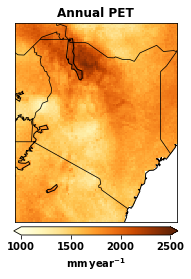

In [24]:
fig = plt.figure()
m = Basemap(projection='cyl', llcrnrlat=min(lats), 
            urcrnrlat=max(lats), llcrnrlon=min(lons),
            urcrnrlon=max(lons), resolution='l')

cs4 = plt.imshow(data, interpolation='nearest', cmap=cmap,
                     extent=[min(lons), max(lons), 
                             min(lats), max(lats)]) 
m.drawcoastlines(linewidth=1.0)
m.drawcountries(linewidth=0.75)
parallels=np.arange(-90.,90.,10.0)
meridians=np.arange(0.,360.,10.0)

m.drawlsmask(land_color=(0,0,0,0), ocean_color='white', lakes=False) 
plt.title(title, fontweight='bold', loc='center')
cb4 = plt.colorbar(cs4, label=cbar_label, shrink=0.4, 
                   pad=0.02, extend='both', orientation='horizontal')
cb4.mappable.set_clim(climin, climax)
plt.tight_layout()  

---
## <span style='background :red' > EXERCISE 2 </span>
Based on the above example on generating regional PET data please do the folowing.

    1. Generate a 5 year dataset for Uganda.
    2. use Method 1 for temperaature adjustment.
    3. generate comparison plots side-by-side (write your own visualization code using python subplots)                        
       for the average  annual PET values of the non-adjusted PET and adjusted PET.
---   

## 2. Batch job submission 
In order to run the CUWALID model, we use the High Performance Computers (HPC) provided by institutes. These HPC's are better for running multiple jobs at the same time. This will save time and allow us to run models that use large data.

Here, we discuss on how you can submit multiple jobs to HPC. ***Please notice that this is not the only way to do the work but just to share one way of doing it***.

### 2.1 creating directories to hold necessary files
The first step we need to do is create three important directories in our home directory. These are:

* bSub_runME
* bSub_logME
* bSub_doneME

You can create these directories by runing the mkdir command in the terminal. Here is the command
* `mkdir bSub_runME`
* `mkdir bSub_logME`
* `mkdir bSub_doneME`

Once you create these directories you can use them anytime for any job submission (i.e No need to make these directories everytime).

#### How do we use these three directories?
The **bSub_runME** directory is used to save our bash files (e.g ***myjob.bash***) that contain all the necessary submission commands and the job to be run.

The **bSub_logME** directory is used to save error files and output files from the job we are running. If there isan error and the job is cancelled you can go tho this directory and read the error message in the ***jobid.error*** file. If there are any print statments in your job or any other print that would have been printed on the terminal will be saved in the ***jonid.out*** file.

The **bSub_doneME** directory is used to save our bash files (e.g ***myjob.bash***) after the job is submitted. Hence, if there is an error and you have to run the job again you can easily move the bash files from this directory to the bSub_runME directory without creating them again.

### 2.2 Creating the bash files
In order to submit multiple jobs to HPC, we need to follow certain commands that are set by the institute. Hence, we can prepare a python script to write these bash files so that we save time to write each file mannually. The following python script **write_bash_files.py** is provided to prepare the bash files used in the job sumbission. Below, we will discuss how it works using one example function in the script.

In [25]:
# This script prepare the .bash file
# containing the arguments for downloading data
import numpy as np
def write_bsub(year):
    # file name to be saved in the bSub_runME directory
    run_file = 'bSub_runMe/imerg_download_' + str(year) + '.bash'  
    # create empty array to hold the lines
    lines = []                
    # this is internal command indicateing it ia a bash file
    lines.append('#!/bin/bash'+'\n')      
    # job name
    lines.append('#SBATCH --job-name=i' + str(year) +'\n') 
    # time required to run job 
    lines.append('#SBATCH --time=0:15:00'+'\n') 
    # number of nodes requested for the job
    lines.append('#SBATCH --nodes=1'+'\n')  
    # number of task allocated for each node
    lines.append('#SBATCH --ntasks-per-node=1'+'\n') 
    # RAM space requested for the job 
    lines.append('#SBATCH --mem=20gb'+'\n')     
    #  account name 
    lines.append('#SBATCH --account=geog014522'+'\n') 
    # this is internal command for SLURM
    lines.append('#cd $SLURM_SUBMIT_DIR'+'\n') 
    # your home directory wher you run the job from
    lines.append('cd /user/home/fp20123/'+' '+'\n')  
    # which ever python you want to use
    lines.append('module add lang/python/anaconda/3.7-2019.10'+' '+'\n') 
    # this is if you using your own python environment
    lines.append('source /user/home/fp20123/my_uavproject/bin/activate'+' '+'\n') 
    # the python script you want to run
    lines.append('python /user/home/fp20123/my_python_code.py ' + str(year) +'\n') 
    # writing file
    f = open(run_file, 'w')   
    for line in lines:
        f.write(line)
    #  close file
    f.close()                
    return 'done'

The above function helps us write the bash files with the necessary commands for the HPC job submission.
As you can see, most of the lines are common and similar required by the HPC, hence, we can use this function to write any bash file we need with little modification. An example of the bash file produced using this function is shown below.

<table>
    <tr>
        <td> 
            <img src="bashfile.png"align="center" width="800"/> 
        </td> 
    </tr>
</table>

This will be what is written in the imerg_download_2012.bash according to the example. 

If there are multiple jobs that use similar python scripts, then what you have to do is run above function to write the bash files with same ***suffix*** and a differetiating ***prefix*** so that we can submit it at the same time. In the above example we can see the file name is **imerg_download_year.bash** here the imerg_download is the prefix while the year is suffix. Now we can write any number of years we want to download (e.g imerg_download_2018.bash, imerg_download_2019.bash, ...).  Once we prepare these files, then we are ready to submit multiple jobs to the HPC.

### 1.3 Submitting multiple jobs
Once we prepare the bash files containing the jobs we want to run on HPC next is to use a little shell script to submit the jobs. The shell script is given as **runBashFiles.sh**. The file contains a few lines of code that allows to read all the bash files we prepare and sumbit it to the HPC. Here is an example file looks like


<table>
    <tr>
        <td> 
            <img src="shellfile.png"align="center" width="800"/> 
        </td> 
    </tr>
</table>

In the above image as you can see from line 5, all the files that start with **imerg_download_** will be submited to the HPC and the files will be moved to the **bSub_doneME** directory we create earlier (Line 7).

Line 6 is where you see the ***.error*** and ***.out*** files that we discussed above to put any error message and output message from the job will be printed and svaed in the **bSub_logME** directory. 

---
## <span style='background :red' > EXERCISE 3 </span>
Based on the above example please try to do the following

    1. Write a python script that calculates area of a circle with radius as an input argument. 
    2. Print the area of the circle as an output.
    3. Write 5 bash  files with diffrent radius values.
    4. Submit the job to the HPC.
    5. Check the results in the output file.
---   